### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

### Import Necessary Libraries

In [5]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
# 讀取資料

# Penn Tree Back dataset
with open("ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [7]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [9]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
        
            # hint: 請計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
            ### <your code> ###
    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            ### <your code> ###
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        
        ### <your code> ###
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885720 words
After subsampling: 437103 words


### 定義Skip-gram使用的Dataset與collate function

In [11]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        ### <your code> ###
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx],self.all_contexts[idx],self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            ### <your code> ###
            all_contexts+=line[self.window_size:-self.window_size]
            
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_targets.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in cur_exists_words]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for targets in self.all_targets:
            ### <your code> ###
            negatives = []
            while len(negatives) < self.num_negatives:  
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=100000)
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                if neg_candidate[i] != targets:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        ### <your code> ###
        contexts += [context]
        target_negative += [target + negative]
        labels += [[1]*len(target) + [0]*len(negative)]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [12]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size,embed_size)
        self.out_embedding = nn.Embedding(vocab_size,embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts).squeeze()#降維
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 訓練

In [13]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 2, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [14]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        optimizer.zero_grad()
        ### <your code> ###
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Batch: 501/537.15625 Loss: 2.94890


  1%|          | 1/100 [00:05<09:06,  5.52s/it]

Epoch: 1/100, Loss: 2.88615
Epoch: 2/100, Batch: 501/537.15625 Loss: 1.19123


  2%|▏         | 2/100 [00:10<08:52,  5.43s/it]

Epoch: 2/100, Loss: 1.18330
Epoch: 3/100, Batch: 501/537.15625 Loss: 0.72150


  3%|▎         | 3/100 [00:16<08:42,  5.38s/it]

Epoch: 3/100, Loss: 0.72280
Epoch: 4/100, Batch: 501/537.15625 Loss: 0.56589


  4%|▍         | 4/100 [00:21<08:31,  5.33s/it]

Epoch: 4/100, Loss: 0.56851
Epoch: 5/100, Batch: 501/537.15625 Loss: 0.49758


  5%|▌         | 5/100 [00:26<08:23,  5.30s/it]

Epoch: 5/100, Loss: 0.50047
Epoch: 6/100, Batch: 501/537.15625 Loss: 0.45767


  6%|▌         | 6/100 [00:31<08:17,  5.30s/it]

Epoch: 6/100, Loss: 0.46058
Epoch: 7/100, Batch: 501/537.15625 Loss: 0.42911


  7%|▋         | 7/100 [00:36<08:09,  5.27s/it]

Epoch: 7/100, Loss: 0.43208
Epoch: 8/100, Batch: 501/537.15625 Loss: 0.40638


  8%|▊         | 8/100 [00:42<08:02,  5.25s/it]

Epoch: 8/100, Loss: 0.40925
Epoch: 9/100, Batch: 501/537.15625 Loss: 0.38766


  9%|▉         | 9/100 [00:47<07:58,  5.25s/it]

Epoch: 9/100, Loss: 0.39056
Epoch: 10/100, Batch: 501/537.15625 Loss: 0.37157


 10%|█         | 10/100 [00:52<07:50,  5.23s/it]

Epoch: 10/100, Loss: 0.37463
Epoch: 11/100, Batch: 501/537.15625 Loss: 0.35779


 11%|█         | 11/100 [00:57<07:44,  5.22s/it]

Epoch: 11/100, Loss: 0.36061
Epoch: 12/100, Batch: 501/537.15625 Loss: 0.34538


 12%|█▏        | 12/100 [01:03<07:40,  5.23s/it]

Epoch: 12/100, Loss: 0.34812
Epoch: 13/100, Batch: 501/537.15625 Loss: 0.33503


 13%|█▎        | 13/100 [01:08<07:35,  5.23s/it]

Epoch: 13/100, Loss: 0.33787
Epoch: 14/100, Batch: 501/537.15625 Loss: 0.32591


 14%|█▍        | 14/100 [01:13<07:28,  5.21s/it]

Epoch: 14/100, Loss: 0.32879
Epoch: 15/100, Batch: 501/537.15625 Loss: 0.31790


 15%|█▌        | 15/100 [01:18<07:23,  5.22s/it]

Epoch: 15/100, Loss: 0.32058
Epoch: 16/100, Batch: 501/537.15625 Loss: 0.31133


 16%|█▌        | 16/100 [01:23<07:18,  5.22s/it]

Epoch: 16/100, Loss: 0.31400
Epoch: 17/100, Batch: 501/537.15625 Loss: 0.30533


 17%|█▋        | 17/100 [01:29<07:12,  5.22s/it]

Epoch: 17/100, Loss: 0.30804
Epoch: 18/100, Batch: 501/537.15625 Loss: 0.30024


 18%|█▊        | 18/100 [01:34<07:06,  5.20s/it]

Epoch: 18/100, Loss: 0.30284
Epoch: 19/100, Batch: 501/537.15625 Loss: 0.29555


 19%|█▉        | 19/100 [01:39<07:03,  5.22s/it]

Epoch: 19/100, Loss: 0.29819
Epoch: 20/100, Batch: 501/537.15625 Loss: 0.29189


 20%|██        | 20/100 [01:44<06:56,  5.21s/it]

Epoch: 20/100, Loss: 0.29434
Epoch: 21/100, Batch: 501/537.15625 Loss: 0.28805


 21%|██        | 21/100 [01:50<06:56,  5.27s/it]

Epoch: 21/100, Loss: 0.29064
Epoch: 22/100, Batch: 501/537.15625 Loss: 0.28531


 22%|██▏       | 22/100 [01:55<06:51,  5.27s/it]

Epoch: 22/100, Loss: 0.28776
Epoch: 23/100, Batch: 501/537.15625 Loss: 0.28193


 23%|██▎       | 23/100 [02:00<06:43,  5.24s/it]

Epoch: 23/100, Loss: 0.28434
Epoch: 24/100, Batch: 501/537.15625 Loss: 0.27967


 24%|██▍       | 24/100 [02:05<06:37,  5.23s/it]

Epoch: 24/100, Loss: 0.28215
Epoch: 25/100, Batch: 501/537.15625 Loss: 0.27716


 25%|██▌       | 25/100 [02:11<06:32,  5.23s/it]

Epoch: 25/100, Loss: 0.27941
Epoch: 26/100, Batch: 501/537.15625 Loss: 0.27528


 26%|██▌       | 26/100 [02:16<06:27,  5.24s/it]

Epoch: 26/100, Loss: 0.27764
Epoch: 27/100, Batch: 501/537.15625 Loss: 0.27307


 27%|██▋       | 27/100 [02:21<06:22,  5.23s/it]

Epoch: 27/100, Loss: 0.27554
Epoch: 28/100, Batch: 501/537.15625 Loss: 0.27129


 28%|██▊       | 28/100 [02:26<06:16,  5.23s/it]

Epoch: 28/100, Loss: 0.27337
Epoch: 29/100, Batch: 501/537.15625 Loss: 0.27017


 29%|██▉       | 29/100 [02:32<06:12,  5.25s/it]

Epoch: 29/100, Loss: 0.27230
Epoch: 30/100, Batch: 501/537.15625 Loss: 0.26804


 30%|███       | 30/100 [02:37<06:06,  5.23s/it]

Epoch: 30/100, Loss: 0.27053
Epoch: 31/100, Batch: 501/537.15625 Loss: 0.26688


 31%|███       | 31/100 [02:42<06:00,  5.22s/it]

Epoch: 31/100, Loss: 0.26913
Epoch: 32/100, Batch: 501/537.15625 Loss: 0.26572


 32%|███▏      | 32/100 [02:47<05:55,  5.23s/it]

Epoch: 32/100, Loss: 0.26772
Epoch: 33/100, Batch: 501/537.15625 Loss: 0.26424


 33%|███▎      | 33/100 [02:52<05:49,  5.21s/it]

Epoch: 33/100, Loss: 0.26672
Epoch: 34/100, Batch: 501/537.15625 Loss: 0.26356


 34%|███▍      | 34/100 [02:58<05:44,  5.21s/it]

Epoch: 34/100, Loss: 0.26583
Epoch: 35/100, Batch: 501/537.15625 Loss: 0.26268


 35%|███▌      | 35/100 [03:03<05:39,  5.22s/it]

Epoch: 35/100, Loss: 0.26481
Epoch: 36/100, Batch: 501/537.15625 Loss: 0.26142


 36%|███▌      | 36/100 [03:08<05:34,  5.23s/it]

Epoch: 36/100, Loss: 0.26360
Epoch: 37/100, Batch: 501/537.15625 Loss: 0.26064


 37%|███▋      | 37/100 [03:13<05:28,  5.21s/it]

Epoch: 37/100, Loss: 0.26290
Epoch: 38/100, Batch: 501/537.15625 Loss: 0.25946


 38%|███▊      | 38/100 [03:18<05:23,  5.22s/it]

Epoch: 38/100, Loss: 0.26153
Epoch: 39/100, Batch: 501/537.15625 Loss: 0.25867


 39%|███▉      | 39/100 [03:24<05:18,  5.23s/it]

Epoch: 39/100, Loss: 0.26119
Epoch: 40/100, Batch: 501/537.15625 Loss: 0.25798


 40%|████      | 40/100 [03:29<05:13,  5.22s/it]

Epoch: 40/100, Loss: 0.26029
Epoch: 41/100, Batch: 501/537.15625 Loss: 0.25712


 41%|████      | 41/100 [03:34<05:07,  5.21s/it]

Epoch: 41/100, Loss: 0.25957
Epoch: 42/100, Batch: 501/537.15625 Loss: 0.25650


 42%|████▏     | 42/100 [03:40<05:09,  5.33s/it]

Epoch: 42/100, Loss: 0.25888
Epoch: 43/100, Batch: 501/537.15625 Loss: 0.25588


 43%|████▎     | 43/100 [03:45<05:02,  5.30s/it]

Epoch: 43/100, Loss: 0.25819
Epoch: 44/100, Batch: 501/537.15625 Loss: 0.25572


 44%|████▍     | 44/100 [03:50<04:55,  5.28s/it]

Epoch: 44/100, Loss: 0.25780
Epoch: 45/100, Batch: 501/537.15625 Loss: 0.25454


 45%|████▌     | 45/100 [03:55<04:50,  5.29s/it]

Epoch: 45/100, Loss: 0.25681
Epoch: 46/100, Batch: 501/537.15625 Loss: 0.25444


 46%|████▌     | 46/100 [04:01<04:44,  5.27s/it]

Epoch: 46/100, Loss: 0.25665
Epoch: 47/100, Batch: 501/537.15625 Loss: 0.25403


 47%|████▋     | 47/100 [04:06<04:38,  5.26s/it]

Epoch: 47/100, Loss: 0.25600
Epoch: 48/100, Batch: 501/537.15625 Loss: 0.25346


 48%|████▊     | 48/100 [04:11<04:34,  5.28s/it]

Epoch: 48/100, Loss: 0.25551
Epoch: 49/100, Batch: 501/537.15625 Loss: 0.25290


 49%|████▉     | 49/100 [04:16<04:28,  5.27s/it]

Epoch: 49/100, Loss: 0.25517
Epoch: 50/100, Batch: 501/537.15625 Loss: 0.25272


 50%|█████     | 50/100 [04:22<04:22,  5.25s/it]

Epoch: 50/100, Loss: 0.25482
Epoch: 51/100, Batch: 501/537.15625 Loss: 0.25203


 51%|█████     | 51/100 [04:27<04:17,  5.25s/it]

Epoch: 51/100, Loss: 0.25427
Epoch: 52/100, Batch: 501/537.15625 Loss: 0.25161


 52%|█████▏    | 52/100 [04:32<04:13,  5.27s/it]

Epoch: 52/100, Loss: 0.25378
Epoch: 53/100, Batch: 501/537.15625 Loss: 0.25074


 53%|█████▎    | 53/100 [04:37<04:07,  5.26s/it]

Epoch: 53/100, Loss: 0.25325
Epoch: 54/100, Batch: 501/537.15625 Loss: 0.25080


 54%|█████▍    | 54/100 [04:43<04:01,  5.24s/it]

Epoch: 54/100, Loss: 0.25310
Epoch: 55/100, Batch: 501/537.15625 Loss: 0.25062


 55%|█████▌    | 55/100 [04:48<03:56,  5.26s/it]

Epoch: 55/100, Loss: 0.25267
Epoch: 56/100, Batch: 501/537.15625 Loss: 0.25015


 56%|█████▌    | 56/100 [04:53<03:50,  5.25s/it]

Epoch: 56/100, Loss: 0.25220
Epoch: 57/100, Batch: 501/537.15625 Loss: 0.24972


 57%|█████▋    | 57/100 [04:58<03:45,  5.24s/it]

Epoch: 57/100, Loss: 0.25176
Epoch: 58/100, Batch: 501/537.15625 Loss: 0.24942


 58%|█████▊    | 58/100 [05:04<03:40,  5.26s/it]

Epoch: 58/100, Loss: 0.25155
Epoch: 59/100, Batch: 501/537.15625 Loss: 0.24909


 59%|█████▉    | 59/100 [05:09<03:35,  5.26s/it]

Epoch: 59/100, Loss: 0.25129
Epoch: 60/100, Batch: 501/537.15625 Loss: 0.24861


 60%|██████    | 60/100 [05:14<03:29,  5.24s/it]

Epoch: 60/100, Loss: 0.25105
Epoch: 61/100, Batch: 501/537.15625 Loss: 0.24872


 61%|██████    | 61/100 [05:19<03:24,  5.25s/it]

Epoch: 61/100, Loss: 0.25107
Epoch: 62/100, Batch: 501/537.15625 Loss: 0.24827


 62%|██████▏   | 62/100 [05:25<03:21,  5.31s/it]

Epoch: 62/100, Loss: 0.25025
Epoch: 63/100, Batch: 501/537.15625 Loss: 0.24807


 63%|██████▎   | 63/100 [05:30<03:15,  5.28s/it]

Epoch: 63/100, Loss: 0.25002
Epoch: 64/100, Batch: 501/537.15625 Loss: 0.24755


 64%|██████▍   | 64/100 [05:35<03:09,  5.27s/it]

Epoch: 64/100, Loss: 0.24958
Epoch: 65/100, Batch: 501/537.15625 Loss: 0.24722


 65%|██████▌   | 65/100 [05:41<03:04,  5.26s/it]

Epoch: 65/100, Loss: 0.24941
Epoch: 66/100, Batch: 501/537.15625 Loss: 0.24726


 66%|██████▌   | 66/100 [05:46<02:58,  5.25s/it]

Epoch: 66/100, Loss: 0.24942
Epoch: 67/100, Batch: 501/537.15625 Loss: 0.24720


 67%|██████▋   | 67/100 [05:51<02:52,  5.23s/it]

Epoch: 67/100, Loss: 0.24933
Epoch: 68/100, Batch: 501/537.15625 Loss: 0.24651


 68%|██████▊   | 68/100 [05:56<02:48,  5.25s/it]

Epoch: 68/100, Loss: 0.24871
Epoch: 69/100, Batch: 501/537.15625 Loss: 0.24677


 69%|██████▉   | 69/100 [06:02<02:42,  5.23s/it]

Epoch: 69/100, Loss: 0.24899
Epoch: 70/100, Batch: 501/537.15625 Loss: 0.24567


 70%|███████   | 70/100 [06:07<02:37,  5.24s/it]

Epoch: 70/100, Loss: 0.24806
Epoch: 71/100, Batch: 501/537.15625 Loss: 0.24633


 71%|███████   | 71/100 [06:12<02:32,  5.25s/it]

Epoch: 71/100, Loss: 0.24835
Epoch: 72/100, Batch: 501/537.15625 Loss: 0.24566


 72%|███████▏  | 72/100 [06:17<02:27,  5.26s/it]

Epoch: 72/100, Loss: 0.24793
Epoch: 73/100, Batch: 501/537.15625 Loss: 0.24559


 73%|███████▎  | 73/100 [06:23<02:21,  5.25s/it]

Epoch: 73/100, Loss: 0.24803
Epoch: 74/100, Batch: 501/537.15625 Loss: 0.24528


 74%|███████▍  | 74/100 [06:28<02:16,  5.25s/it]

Epoch: 74/100, Loss: 0.24737
Epoch: 75/100, Batch: 501/537.15625 Loss: 0.24524


 75%|███████▌  | 75/100 [06:33<02:11,  5.28s/it]

Epoch: 75/100, Loss: 0.24723
Epoch: 76/100, Batch: 501/537.15625 Loss: 0.24544


 76%|███████▌  | 76/100 [06:38<02:06,  5.27s/it]

Epoch: 76/100, Loss: 0.24750
Epoch: 77/100, Batch: 501/537.15625 Loss: 0.24504


 77%|███████▋  | 77/100 [06:44<02:00,  5.26s/it]

Epoch: 77/100, Loss: 0.24730
Epoch: 78/100, Batch: 501/537.15625 Loss: 0.24497


 78%|███████▊  | 78/100 [06:49<01:56,  5.28s/it]

Epoch: 78/100, Loss: 0.24679
Epoch: 79/100, Batch: 501/537.15625 Loss: 0.24435


 79%|███████▉  | 79/100 [06:54<01:50,  5.26s/it]

Epoch: 79/100, Loss: 0.24666
Epoch: 80/100, Batch: 501/537.15625 Loss: 0.24450


 80%|████████  | 80/100 [06:59<01:45,  5.26s/it]

Epoch: 80/100, Loss: 0.24659
Epoch: 81/100, Batch: 501/537.15625 Loss: 0.24462


 81%|████████  | 81/100 [07:05<01:40,  5.28s/it]

Epoch: 81/100, Loss: 0.24686
Epoch: 82/100, Batch: 501/537.15625 Loss: 0.24440


 82%|████████▏ | 82/100 [07:10<01:34,  5.27s/it]

Epoch: 82/100, Loss: 0.24622
Epoch: 83/100, Batch: 501/537.15625 Loss: 0.24387


 83%|████████▎ | 83/100 [07:16<01:31,  5.36s/it]

Epoch: 83/100, Loss: 0.24587
Epoch: 84/100, Batch: 501/537.15625 Loss: 0.24380


 84%|████████▍ | 84/100 [07:21<01:25,  5.34s/it]

Epoch: 84/100, Loss: 0.24617
Epoch: 85/100, Batch: 501/537.15625 Loss: 0.24348


 85%|████████▌ | 85/100 [07:26<01:19,  5.31s/it]

Epoch: 85/100, Loss: 0.24553
Epoch: 86/100, Batch: 501/537.15625 Loss: 0.24320


 86%|████████▌ | 86/100 [07:31<01:13,  5.28s/it]

Epoch: 86/100, Loss: 0.24533
Epoch: 87/100, Batch: 501/537.15625 Loss: 0.24349


 87%|████████▋ | 87/100 [07:37<01:08,  5.26s/it]

Epoch: 87/100, Loss: 0.24563
Epoch: 88/100, Batch: 501/537.15625 Loss: 0.24293


 88%|████████▊ | 88/100 [07:42<01:03,  5.27s/it]

Epoch: 88/100, Loss: 0.24528
Epoch: 89/100, Batch: 501/537.15625 Loss: 0.24292


 89%|████████▉ | 89/100 [07:47<00:57,  5.26s/it]

Epoch: 89/100, Loss: 0.24525
Epoch: 90/100, Batch: 501/537.15625 Loss: 0.24280


 90%|█████████ | 90/100 [07:52<00:52,  5.24s/it]

Epoch: 90/100, Loss: 0.24497
Epoch: 91/100, Batch: 501/537.15625 Loss: 0.24252


 91%|█████████ | 91/100 [07:58<00:47,  5.26s/it]

Epoch: 91/100, Loss: 0.24453
Epoch: 92/100, Batch: 501/537.15625 Loss: 0.24250


 92%|█████████▏| 92/100 [08:03<00:41,  5.24s/it]

Epoch: 92/100, Loss: 0.24471
Epoch: 93/100, Batch: 501/537.15625 Loss: 0.24242


 93%|█████████▎| 93/100 [08:08<00:36,  5.25s/it]

Epoch: 93/100, Loss: 0.24441
Epoch: 94/100, Batch: 501/537.15625 Loss: 0.24192


 94%|█████████▍| 94/100 [08:13<00:31,  5.25s/it]

Epoch: 94/100, Loss: 0.24433
Epoch: 95/100, Batch: 501/537.15625 Loss: 0.24220


 95%|█████████▌| 95/100 [08:19<00:26,  5.25s/it]

Epoch: 95/100, Loss: 0.24458
Epoch: 96/100, Batch: 501/537.15625 Loss: 0.24248


 96%|█████████▌| 96/100 [08:24<00:20,  5.24s/it]

Epoch: 96/100, Loss: 0.24460
Epoch: 97/100, Batch: 501/537.15625 Loss: 0.24201


 97%|█████████▋| 97/100 [08:29<00:15,  5.26s/it]

Epoch: 97/100, Loss: 0.24434
Epoch: 98/100, Batch: 501/537.15625 Loss: 0.24203


 98%|█████████▊| 98/100 [08:34<00:10,  5.26s/it]

Epoch: 98/100, Loss: 0.24410
Epoch: 99/100, Batch: 501/537.15625 Loss: 0.24186


 99%|█████████▉| 99/100 [08:40<00:05,  5.25s/it]

Epoch: 99/100, Loss: 0.24389
Epoch: 100/100, Batch: 501/537.15625 Loss: 0.24232


100%|██████████| 100/100 [08:45<00:00,  5.25s/it]

Epoch: 100/100, Loss: 0.24411


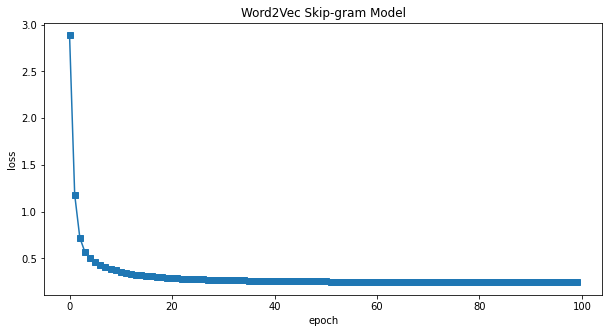

In [15]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [16]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.386: holidays.
cosine sim=0.371: credible.
cosine sim=0.353: me.
cosine sim=0.347: promotion.
